In [103]:
from pathlib import Path
from collections import defaultdict
from pytube import YouTube
import whisper
import openai
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.validation import check_symmetric
from sklearn.cluster import SpectralClustering
import numpy as np

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
import pickle

from summarize import enrich_whisper
from commons import nice_time

In [12]:
import sys
# !{sys.executable} -m spacy download en_core_web_trf
# !{sys.executable} -m spacy download en_core_web_lg

In [13]:
spacy.prefer_gpu()
# nlp = spacy.load("en_core_web_trf")
nlp = spacy.load("en_core_web_lg")

In [14]:
TARGET_URL = "https://youtu.be/K4xqY-3ODKY"
SAVE_PATH = Path("/mnt/storage/newsboy/")

In [15]:
openai.api_key = open("openai.key").read().strip()


In [29]:
%%time
yt = YouTube(TARGET_URL)

CPU times: user 64 µs, sys: 24 µs, total: 88 µs
Wall time: 90.1 µs


In [35]:
%%time
c = yt.captions['a.en']

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 13.4 µs


In [36]:
%%time
x = c.xml_captions

CPU times: user 26.1 ms, sys: 2.19 ms, total: 28.3 ms
Wall time: 4.53 s


In [48]:
x[:1000]

'<?xml version="1.0" encoding="utf-8" ?><timedtext format="3">\n<head>\n<ws id="0"/>\n<ws id="1" mh="2" ju="0" sd="3"/>\n<wp id="0"/>\n<wp id="1" ap="6" ah="20" av="100" rc="2" cc="40"/>\n</head>\n<body>\n<w t="0" id="1" wp="1" ws="1"/>\n<p t="0" d="7560" w="1"><s ac="248">this</s><s t="599" ac="248"> is</s><s t="719" ac="248"> my</s><s t="1020" ac="248"> first</s><s t="1260" ac="248"> video</s><s t="1560" ac="248"> update</s><s t="2220" ac="248"> coming</s><s t="2639" ac="248"> to</s></p>\n<p t="2869" d="4691" w="1" a="1">\n</p>\n<p t="2879" d="7101" w="1"><s ac="248">you</s><s t="181" ac="248"> from</s><s t="801" ac="225"> Limassol</s><s t="2301" ac="244"> Cyprus</s><s t="3301" ac="248"> on</s><s t="3781" ac="248"> this</s><s t="4440" ac="248"> Sunday</s></p>\n<p t="7550" d="2430" w="1" a="1">\n</p>\n<p t="7560" d="2420" w="1"><s ac="248">morning</s></p>\n<p t="13330" w="1" a="1">\n</p>\n<p t="13340" d="6120" w="1"><s ac="231">oranges</s></p>\n<p t="15289" d="4171" w="1" a="1">\n</p>

In [39]:
import xml.etree.ElementTree as ET
tree = ET.fromstring(x)

In [45]:
elem.tag

'p'

In [62]:
# !{sys.executable} -m pip install fasttext

  Using cached fasttext-0.9.2-cp310-cp310-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 kB 1.4 MB/s eta 0:00:001.4 MB/s eta 0:00:01


In [63]:
import fasttext

In [109]:
ws = []
current_p_time = 0
for elem in tree.iter():
    if elem.tag not in 'sp':
        continue

    if elem.tag == 'p':
        current_p_time = int(elem.attrib.get('t', '0'))
    elif elem.tag == 's':
        w = elem.text.strip()
        ws.append({'text': w, 
                   'start': (int(elem.attrib.get('t', '0')) + current_p_time) // 1000,
                   'vector': nlp(w).vector})



In [37]:
summarize("This is my first video update coming to you from Limassol, Cyprus on this Sunday morning. Look at all the oranges just like falling right off the trees. Let's talk about the news everybody and what should we start off with. Okay, so we had something go down in Iran yesterday evening and I think there was a lot of misinformation floating around the interwebs as to what was going on and the actual scale of these attacks. That's what it appears to be, some sort of drone attack on some sort of military facilities or something like that. And at first, as this story was breaking, it seemed like there was a lot of cities under attack, a lot of drones hitting out at Iran. But as the evening went along, I think we got more clarity as to what was happening and it looks like, I don't want to say it was a minor attack, like a minor incident, but it doesn't look as large scale as what it initially appeared to be. I'm just going to read you what the Iranian Ministry of Defense said about an attack which appears to have taken place in just one facility in Isfahan. I know there were videos going around yesterday evening of attacks taking place in various cities that one report said in nine cities in Iran, but it looks like this was just one city where this occurred. I can't confirm any of this. I'm just going to read you what the Iranian Ministry of Defense said in a statement. And I quote, today at 2330, there was an unsuccessful attack using a UAV on one of the workshop complexes of the Ministry of Defense in Isfahan. One drone was shot down by anti-aircraft fire while two others fell on the roof of the building. Fortunately, there were no casualties. Only minor damage was caused to the roof of the workshop. The equipment is intact. The Ministry of Defense and support of the armed forces assures that it will continue its security activities and these provocations will not affect the life of the country. So an attack on workshop facilities. Nice wheels. Really, really nice wheels here. So I don't know. I don't know if this was a large scale attack. I don't know if this was as the Iranian Ministry of Defense puts it, just a drone attack on a drone attack on one workshop facility. No real way to confirm this, but that's what the Ministry of Defense is saying. I wonder if that workshop facility was allegedly, allegedly manufacturing the drones that allegedly the Iranians are providing to Russia. And that has the whole collective West in a fit about those Iranian drones.")

'There was an alleged drone attack on military facilities in Iran on Sunday, which appears to have been a minor attack.'

'\nThere was an attack on a military facility in Iran yesterday evening which appears to have been a drone attack. The Iranian Ministry of Defense is saying that only minor damage was caused to the roof of the workshop and that the equipment is intact.'

In [44]:
nice_time(sents[sent_ids[c['boundery'][0]]]['start'])

'17:18'

In [46]:
lines = []
for c in clusters:
    t = nice_time(sent_ids[c['boundery'][0]])
    texts = (sents[sent_ids[i]]['text'] for i in range(sent_ids[c['boundery'][0]], sent_ids[c['boundery'][1]]))
    paragraph = ' '.join(texts)
    sm = summarize(paragraph).replace('\n\n', '\n')
    lines.append(f'[{t}] {sm}')


[0:00] There was an attack on Iranian military facilities in Iran yesterday evening, which appears to have been a drone attack. The scale of the attack is not as large as initially thought, and there have been no reports of any casualties.

[0:27] 1. The Ukrainian government is seeking long range missiles to help fortify its defenses against Russian aggression.

2. Pentagon factions are pushing for F-16s to be sent to Ukraine, but the Biden White House is reportedly considering other options.

3. Tanks are useless in the face of long range missiles, and F-16s are the only real solution.

[0:43] There are conflicting reports about whether or not the US is going to send new Abrams tanks to Ukraine. Some outlets are reporting that the tanks will not have the super high tech armor that is currently used on the Challengers, while other sources are claiming that the tanks will still have this armor. Additionally, the Sun is reporting that the British Defense Ministry is afraid that Challenge

IndexError: list index out of range

In [254]:
assert len(sent_ids) == len(sc.labels_)

In [266]:
c = 16
[(i, sents[i]['text']) for i, l in zip(sent_ids, sc.labels_) if l==c]

[(248, 'And he got heckled.'),
 (255, 'And he said this.'),
 (261,
  'Do I need to comment on this statement from Tucker Carlson? Oh man, oh man.'),
 (262, 'Olyf, why does Tucker hate me so much? Trudeau, you idiot.'),
 (263, "Tucker hates you because you're an idiot."),
 (265, "Trudeau, I'm not an idiot."),
 (267, "But you, you're an idiot."),
 (268, "Oh boy, anyway, I'm gonna leave it there.")]

In [93]:
V.sum(axis=1)

array([ 93.03302  , 121.271774 , 106.929054 , 150.62851  , 138.14307  ,
       134.46407  , 144.51631  , 134.29123  , 145.58508  ,  74.881775 ,
       116.187485 , 113.373474 ,  97.83391  , 114.14494  ,  91.80036  ,
        82.35814  , 124.48285  , 103.44945  ,  35.981056 ,  60.64514  ,
        98.22127  , 120.16748  , 118.70374  , 134.9397   , 121.935425 ,
       103.482635 , 126.78444  ,  86.91917  ,  73.1559   ,  57.81488  ,
       126.95194  , 139.41022  , 110.739586 ,  89.40785  ,  73.1559   ,
       101.08851  ,  93.91112  , 128.25955  , 133.85898  , 138.92436  ,
       134.92198  , 100.08655  , 137.99352  , 133.54228  , 116.3912   ,
       132.95409  , 109.041275 , 120.928665 , 146.67685  , 130.17291  ,
       130.03691  , 141.03543  ,  47.59544  , 130.7719   ,  81.77079  ,
       116.28183  ,  50.351227 , 108.47586  ,  98.22127  , 132.88585  ,
       107.64075  , 103.47052  , 137.8359   ,  26.771965 , 103.090126 ,
       125.76318  , 130.10414  , 129.69771  ,  84.617584 , 100.0

In [37]:
vectors = {}
for si, sent in enumerate(sents):
    v = np.sum([tok.vector for tok in nlp(sent['text'] if not tok.is_stop and tok.is_alpha], axis=0)
    v_norm = v / (np.linalg.norm(v) + 1e-16)
    vectors[si] = v_norm


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
assert lang == 'en', 'Spacy finds noun_chunks only for english now'

ents = defaultdict(list)

for si, sent in enumerate(sents):
    doc = nlp(sent['text'])
    for ent in doc:
        if ent.lemma_ in stops:
            continue
        if ent.pos_ not in {"NOUN", "PROPN"}:
            continue
        # print(ent.text, ent.lemma_, ent.pos_, ent.is_stop)
        ents[ent.lemma_].append(si)
    break
    


In [91]:
rms = []
for e, v in ents.items():
    if len(v) == 1:
        rms.append(e)
for e in rms:
    del ents[e]

max_val = 0
for e, v in ents.items():
    max_val = max(max_val, max(v))

max_val


mentions = np.zeros(shape=[len(ents), max_val+1])

ent2id = {}
for i, (e, v) in enumerate(ents.items()):
    ent2id[e] = i

for e, vs in ents.items():
    for v in vs:
        mentions[ent2id[e], v] = 1


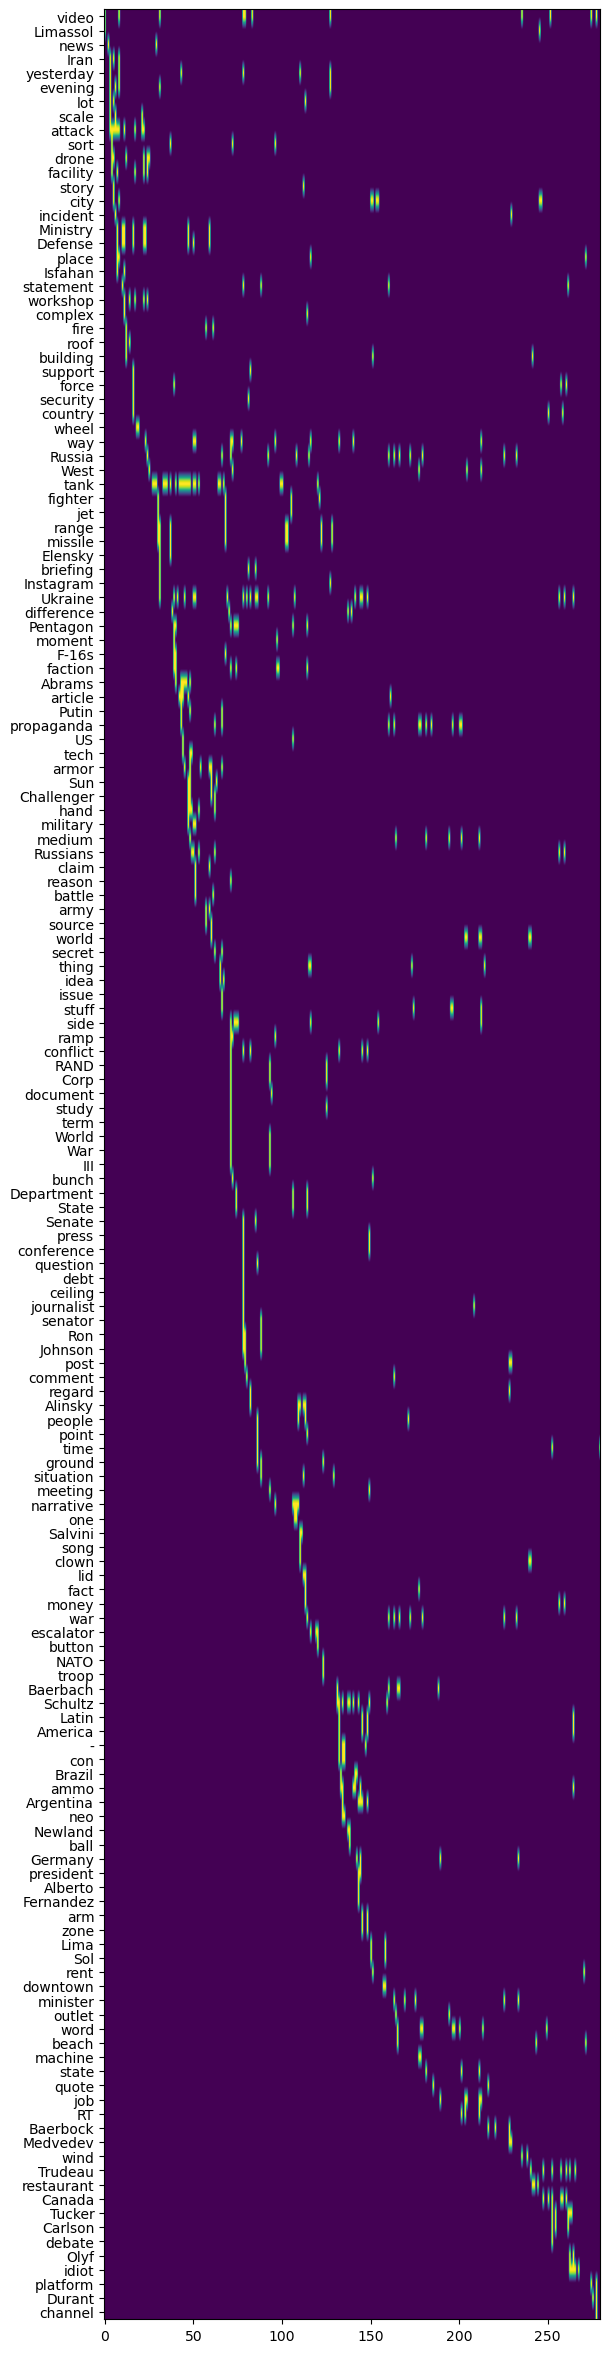

In [92]:
plt.figure(figsize=(10, 30))
plt.imshow(mentions, aspect=8)
ent_labels, ent_ids = zip(*ent2id.items())
plt.yticks(labels=ent_labels, ticks=ent_ids);

In [93]:
def rargmin(arr):
    i = np.argmin(arr[::-1])
    return len(arr) - i - 1


def rargmax(arr):
    i = np.argmax(arr[::-1])
    return len(arr) - i - 1


assert rargmin([1, 0, 0, 2]) == 2
assert rargmin([-1, 0, 3, 2]) == 0

In [106]:
def split_to_two(mentions):
    errs = []
    expls = []
    n = mentions.shape[1]
    for k in range(1, n):
        m1 = mentions[:, (k-10):k]
        m2 = mentions[:, k:(k+10)]

        expl = np.sum((m1.sum(axis=1) > 0) * (m2.sum(axis=1) == 0)) + \
               np.sum((m1.sum(axis=1) == 0) * (m2.sum(axis=1) > 0))
        err = np.sum((m1.sum(axis=1) > 0) * (m2.sum(axis=1) > 0)) - expl
        errs.append(err)
        expls.append(expl)

    return int(rargmin(errs)), errs

In [107]:
def recursive_split(mentions, start=0, end=None):
    if end is None:
        end = mentions.shape[1]
    n = end-start
    if n-1 < 10:
        return []
    k_, _ = split_to_two(mentions[:, start:end])
    k = k_ + start
    if k in {start, end}:
        return []
    if end - k < 5 or k - start < 5:
        return []
    return recursive_split(mentions, start, k) + \
           [k] + \
           recursive_split(mentions, k, end)


In [108]:
splits = recursive_split(mentions)
splits

[25, 38, 68, 77, 89, 105, 115, 124, 129, 137, 149, 156, 220, 238, 246, 267]

In [109]:
texts = []
for s, e in zip([0] + splits, splits + [mentions.shape[1]]):
    t = ' '.join(s['text'] for s in sents[s:e])
    texts.append(t)


In [104]:
print('\n\n'.join([f"[{i}] {t}"for i, t in enumerate(texts)]))

[0] This is my first video update coming to you from Limassol, Cyprus on this Sunday morning. Look at all the oranges just like falling right off the trees. Let's talk about the news everybody and what should we start off with. Okay, so we had something go down in Iran yesterday evening and I think there was a lot of misinformation floating around the interwebs as to what was going on and the actual scale of these attacks. That's what it appears to be, some sort of drone attack on some sort of military facilities or something like that. And at first, as this story was breaking, it seemed like there was a lot of cities under attack, a lot of drones hitting out at Iran. But as the evening went along, I think we got more clarity as to what was happening and it looks like, I don't want to say it was a minor attack, like a minor incident, but it doesn't look as large scale as what it initially appeared to be. I'm just going to read you what the Iranian Ministry of Defense said about an atta

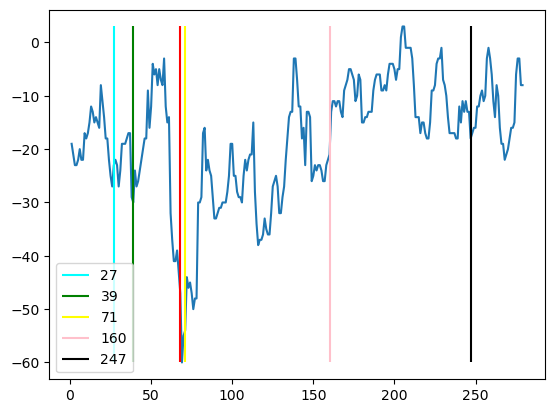

In [110]:
m = mentions[:,:]
k, errs = split_to_two(m)
plt.plot(range(1, m.shape[1]), errs)
plt.vlines(k, ymin=np.min(errs), ymax=np.max(errs), color='red')
plt.vlines(27, ymin=np.min(errs), ymax=np.max(errs), color='cyan', label='27')
plt.vlines(39, ymin=np.min(errs), ymax=np.max(errs), color='green', label='39')
plt.vlines(71, ymin=np.min(errs), ymax=np.max(errs), color='yellow', label='71')
plt.vlines(160 , ymin=np.min(errs), ymax=np.max(errs), color='pink', label='160')
plt.vlines(247 , ymin=np.min(errs), ymax=np.max(errs), color='black', label='247')
plt.legend();

In [74]:
for i, s in enumerate(sents):
    print(i, s['text'])
    

0 This is my first video update coming to you from Limassol, Cyprus on this Sunday morning.
1 Look at all the oranges just like falling right off the trees.
2 Let's talk about the news everybody and what should we start off with.
3 Okay, so we had something go down in Iran yesterday evening and I think there was a lot of misinformation floating around the interwebs as to what was going on and the actual scale of these attacks.
4 That's what it appears to be, some sort of drone attack on some sort of military facilities or something like that.
5 And at first, as this story was breaking, it seemed like there was a lot of cities under attack, a lot of drones hitting out at Iran.
6 But as the evening went along, I think we got more clarity as to what was happening and it looks like, I don't want to say it was a minor attack, like a minor incident, but it doesn't look as large scale as what it initially appeared to be.
7 I'm just going to read you what the Iranian Ministry of Defense said a

In [22]:
ss = []
n = mentions.shape[1]
ks = range(1, n)
for k in ks:
    m1 = mentions[:, 0:k]
    m2 = mentions[:, k:]
    p1 = m1.sum(axis=1) / mentions.sum(axis=1)
    p2 = m2.sum(axis=1) / mentions.sum(axis=1)
    p1[np.isnan(p1)] = 0
    p2[np.isnan(p2)] = 0
    s = p1.sum() * m1.shape[1] + p2.sum() * m2.shape[1]
    ss.append(s)
km = np.argmin(ss)
ks[km], sents[ks[km]]

(166, When can we get to that?)

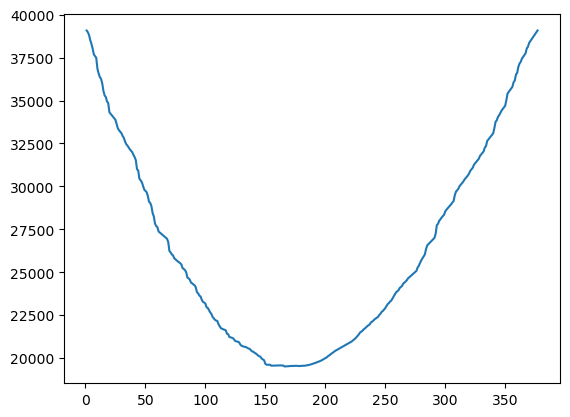

In [23]:
plt.plot(range(1, n), ss)

In [17]:
ss

[45470.18095238095,
 45349.961904761905,
 45158.89563269877,
 44833.85181037701,
 44577.992783700065,
 44281.7857374364,
 43915.93982111625,
 43778.367552476244,
 43642.5954809819,
 42931.792404393935,
 42637.08638863986,
 42390.22972353514,
 42263.635528164086,
 41956.34942119584,
 41494.75937255525,
 41214.714778460104,
 41108.67018436496,
 40831.62559026981,
 40726.58099617466,
 40165.140921853534,
 40062.79689273013,
 39960.45286360675,
 39858.10883448335,
 39751.479091074245,
 39633.96796238375,
 39348.11669134973,
 39059.21150015319,
 38919.37737753721,
 38813.28559258357,
 38713.63380762992,
 38540.11189280613,
 38412.38218577457,
 38176.74145359793,
 37983.87455494126,
 37873.6460437426,
 37748.39509540662,
 37623.50778343426,
 37498.44169279377,
 37373.74642282196,
 37196.20768780457,
 37029.583633104994,
 36822.28717185712,
 36275.110810859886,
 36177.11792130722,
 35494.77703216176,
 35372.71397124256,
 35224.295325423016,
 34981.844204733716,
 34741.5979350895,
 34631.53532

In [15]:
mentions.shape[1]

362

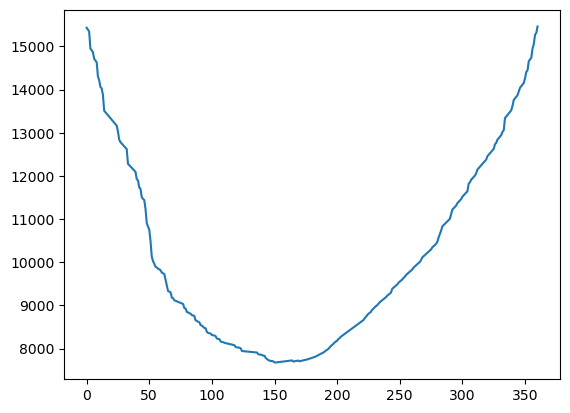

In [16]:
plt.plot(ss)

In [89]:
k = 150
m1 = mentions[:, 0:k]
m2 = mentions[:, k:]

In [93]:
p1 = m1.sum(axis=1) / mentions.sum(axis=1)
p2 = m2.sum(axis=1) / mentions.sum(axis=1)

In [97]:
def entropy(p):
    p_ = p[(p>0) * (p<1)]
    return (p_*np.log(p_)).sum()


In [100]:
entropy(p1) / m1.shape[0] + entropy(p2) / m2.shape[0]

-0.1464690049608315

In [101]:
entropy(mentions)

0.0

In [106]:
p1.sum() * m1.shape[1] + p2.sum() * m2.shape[1]

7701.38111888112

In [105]:
mentions.shape[0] * mentions.shape[1]

15566

In [56]:
for s in transcription['segments']:
    print(f"[{nice_time(s['start'])}]", s['text'].strip())

[0:00] This is my first video update coming to you from Limassol, Cyprus on this Sunday morning.
[0:08] Look at all the oranges just like falling right off the trees.
[0:20] Let's talk about the news everybody and what should we start off with.
[0:27] We had something go down in Iran yesterday evening.
[0:33] I think there was a lot of misinformation floating around the interwebs as to what was going on
[0:40] and the actual scale of these attacks.
[0:44] That's what it appears to be, some sort of drone attack on some sort of military facilities or something like that.
[0:54] At first, as the story was breaking, it seemed like there was a lot of cities under attack, a lot of drones hitting out at Iran.
[1:01] But as the evening went along, I think we got more clarity as to what was happening.
[1:06] And it looks like, I don't want to say it was a minor attack, like a minor incident,
[1:12] but it doesn't look as large scale as what it initially appeared to be.
[1:19] I'm just going to 

In [28]:
s['start']

{'id': 0,
 'seek': 0,
 'start': 0.0,
 'end': 8.0,
 'text': ' This is my first video update coming to you from Limassol, Cyprus on this Sunday morning.',
 'tokens': [50364,
  639,
  307,
  452,
  700,
  960,
  5623,
  1348,
  281,
  291,
  490,
  16406,
  640,
  401,
  11,
  10295,
  49074,
  322,
  341,
  7776,
  2446,
  13,
  50764,
  50764,
  2053,
  412,
  439,
  264,
  35474,
  445,
  411,
  7440,
  558,
  766,
  264,
  5852,
  13,
  51394,
  51394,
  961,
  311,
  751,
  466,
  264,
  2583,
  2201,
  293,
  437,
  820,
  321,
  722,
  766,
  365,
  13,
  51726,
  51726],
 'temperature': 0.0,
 'avg_logprob': -0.2679907815498218,
 'compression_ratio': 1.3680981595092025,
 'no_speech_prob': 0.0033165060449391603}

In [287]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [288]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B")

OSError: Can't load the model for 'EleutherAI/gpt-j-6B'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'EleutherAI/gpt-j-6B' is the correct path to a directory containing a file named pytorch_model.bin, tf_model.h5, model.ckpt or flax_model.msgpack.

In [110]:
def similiarity_sents(sents, neigbors_count=20):
    sent_ids = [i for i, s in enumerate(sents) if s['vector'] is not None]
    V = cosine_similarity(np.array([sents[i]['vector'] for i in sent_ids]))

    for i in range(len(V)):
        if i-neigbors_count > 0:
            V[i][:(i-neigbors_count)] = 0
        V[i][(i+neigbors_count+1):] = 0

    not_connected_sents = np.where(np.sum(V**2, axis=0) < 2)[0]
    not_connected_sents

    sent_ids = [si for i, si in enumerate(sent_ids) if i not in not_connected_sents]
    V = np.delete(V, not_connected_sents, axis=0)
    V = np.delete(V, not_connected_sents, axis=1)

    check_symmetric(V, raise_exception=True)
    assert len(V) == len(sent_ids)

    return V, sent_ids


def sent_ends(part):
    return part.strip().endswith('.')


def suppress_lonely_labels(L):
    R = np.array(L)
    changes_count = len(R)
    iter_count = 0
    while changes_count > 0 and iter_count < 10:
        R_next = np.array(R)
        for i in range(1, len(R)-1):
            if R[i-1] == R[i+1] and R[i] != R[i-1]:
                R_next[i] = R[i-1]
        changes_count = (R != R_next).sum()
        R = R_next
        iter_count += 1
    return R


assert list(suppress_lonely_labels([0, 1, 0])) == [0, 0, 0]
assert list(suppress_lonely_labels([0, 1, 0, 1, 0])) == [0, 0, 0, 0, 0]
assert list(suppress_lonely_labels([0, 1, 2, 1, 0])) == [0, 1, 1, 1, 0]
suppress_lonely_labels([
        4,  4,  4,  4,  4,  4,  4, 17, 17, 17, 17, 17,  4, 17,  4,  4, 17,
       17,  4,  4,  4, 17, 17, 17, 17, 17, 17,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6, 12, 12, 12, 12, 12, 12,  0, 12,
       12,  0,  0, 12,  0, 12, 12,  0, 12, 12, 12, 12, 12,  0,  0,  0,  0,
       12,  0,  0,  9,  0,  9,  9,  9,  0,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 14, 14, 14,  1,  1,  1,  1,
        1, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  1,  1,
        1, 11, 11, 11, 15, 11, 11, 11, 11, 11, 11, 15, 11, 11, 11, 15, 11,
       11, 11, 11, 11, 15, 19, 19, 19, 19, 15, 19, 19, 19, 19, 19, 19,  5,
       15, 13,  5,  5, 13,  5, 13, 13, 13, 13, 13,  5, 13, 13,  5, 13,  5,
        5,  5, 13,  5, 13, 13,  5, 13,  7, 13, 13,  8,  8,  8,  8,  8,  8,
        8,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  2,
        2,  7,  2,  2,  2,  2,  2, 16, 16, 16,  2, 16,  2,  2,  2,  2,  2,
        2,  2, 16, 16, 16, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10,  3, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  3,  3,  3, 18,  3,  3,
        3, 18, 18, 18, 18, 18, 18])

def merge_overlapping_labels(L):
    boundery = {}
    for i, l in enumerate(L):
        if l not in boundery:
            boundery[l] = [i, i]
        else:
            boundery[l][1] = i

    clusters = []
    i = 0
    while i < len(L):
        current_cluster = {'labels': {L[i]}, 'boundery': boundery[L[i]]}
        while i < current_cluster['boundery'][1]:
            if L[i] not in current_cluster['labels']:
                current_cluster['labels'].add(L[i])
                current_cluster['boundery'][1] = max(current_cluster['boundery'][1], boundery[L[i]][1])
            i += 1
        clusters.append(current_cluster)
        i += 1

    return clusters


assert merge_overlapping_labels(np.array([
        4,  4,  4,  4,  4,  4,  4, 17, 17, 17, 17, 17,  4, 17,  4,  4, 17,
       17,  4,  4,  4, 17, 17, 17, 17, 17, 17,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6, 12, 12, 12, 12, 12, 12,  0, 12,
       12,  0,  0, 12,  0, 12, 12,  0, 12, 12, 12, 12, 12,  0,  0,  0,  0,
       12,  0,  0,  9,  0,  9,  9,  9,  0,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 14, 14, 14,  1,  1,  1,  1,
        1, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  1,  1,
        1, 11, 11, 11, 15, 11, 11, 11, 11, 11, 11, 15, 11, 11, 11, 15, 11,
       11, 11, 11, 11, 15, 19, 19, 19, 19, 15, 19, 19, 19, 19, 19, 19,  5,
       15, 13,  5,  5, 13,  5, 13, 13, 13, 13, 13,  5, 13, 13,  5, 13,  5,
        5,  5, 13,  5, 13, 13,  5, 13,  7, 13, 13,  8,  8,  8,  8,  8,  8,
        8,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  2,
        2,  7,  2,  2,  2,  2,  2, 16, 16, 16,  2, 16,  2,  2,  2,  2,  2,
        2,  2, 16, 16, 16, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10,  3, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  3,  3,  3, 18,  3,  3,
        3, 18, 18, 18, 18, 18, 18])) == \
    [
        {'labels': {4, 17}, 'boundery': [0, 26]},
        {'labels': {6}, 'boundery': [27, 42]},
        {'labels': {0, 9, 12}, 'boundery': [43, 94]},
        {'labels': {1, 14}, 'boundery': [95, 119]},
        {'labels': {2, 3, 5, 7, 8, 10, 11, 13, 15, 16, 18, 19}, 'boundery': [120, 261]}
    ]

async def summarize_with_llm(text):
    assert text
    response = await openai.Completion.acreate(
      model="text-curie-001",
      prompt=f"{text}\n\nSUMMARY\n",
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )
    # print(f'{text}')
    # print(f'{response["choices"][0]["text"]=}')
    return response["choices"][0]["text"].strip()

def enrich_whisper(transcription):
    segments = transcription['segments']
    _s_ids = [s['id'] for s in segments]
    assert len(set(_s_ids)) == len(_s_ids)

    sents = []
    parts = []
    for s in segments:
        parts.append(segments[s['id']])
        if sent_ends(parts[-1]['text']):
            text = ''.join(p['text'] for p in parts).strip()
            vs = [tok.vector for tok in nlp(text) if not tok.is_stop and tok.is_alpha]
            if vs:
                v = np.sum(vs, axis=0)
                v_norm = v / (np.linalg.norm(v) + 1e-10)
            else:
                v_norm = None
            sents.append({
                'segment_id': parts[0]['id'],
                'start': parts[0]['start'],
                'text': text,
                'vector': v_norm
            })
            parts = []
    return sents


def create_timecodes(sents):
    V, sent_ids = similiarity_sents(sents, 100)
    clusters_count = int(len(sent_ids)/10)
    if clusters_count < 2:
        clusters = [{'boundery': [0, len(sent_ids)-2], 'start': 0.0}]
    else:
        sc = SpectralClustering(affinity="precomputed", n_clusters=clusters_count, assign_labels="discretize").fit(V)
        labels = suppress_lonely_labels(sc.labels_)
        clusters = merge_overlapping_labels(labels)
    # print(f"after fit: {clusters=}")

    lines = []
    for k, c in enumerate(clusters):
        t = nice_time(sents[sent_ids[c['boundery'][0]]]['start'])
        start_id = sent_ids[c['boundery'][0]]
        try:
            end_id = sent_ids[c['boundery'][1]+1]
        except IndexError:
            end_id = len(sents)

        texts = [sents[i]['text'] for i in range(start_id, end_id)]
        paragraph = ' '.join(texts)
        sm = summarize_with_llm(paragraph).replace('\n\n', '\n')
        lines.append(f'[{t}] {sm}')
    return '\n'.join(lines)

In [112]:
sents = ws
V, sent_ids = similiarity_sents(sents, 100)
clusters_count = int(len(sent_ids)/10/10)
if clusters_count < 2:
    clusters = [{'boundery': [0, len(sent_ids)-2], 'start': 0.0}]
else:
    sc = SpectralClustering(affinity="precomputed", n_clusters=clusters_count, assign_labels="discretize").fit(np.abs(V))
    labels = suppress_lonely_labels(sc.labels_)
    clusters = merge_overlapping_labels(labels)
# print(f"after fit: {clusters=}")

lines = []
for k, c in enumerate(clusters):
    t = nice_time(sents[sent_ids[c['boundery'][0]]]['start'])
    start_id = sent_ids[c['boundery'][0]]
    try:
        end_id = sent_ids[c['boundery'][1]+1]
    except IndexError:
        end_id = len(sents)

    texts = [sents[i]['text'] for i in range(start_id, end_id)]
    paragraph = ' '.join(texts)
    sm = (await summarize_with_llm(paragraph)).replace('\n\n', '\n')
    lines.append(f'[{t}] {sm}')
'\n'.join(lines)

"[0:00] So according to various reports, the Iranian government may have conducted drone strikes against military targets in several cities in Iran, including Isfahan. The Iranian Ministry of Defense has stated that the attack was unsuccessful, and that only minor damage was caused to the roof of a workshop. The Pentagon is reportedly trying to get F-16s to Ukraine, in order to counterbalance Russian equipment. Some commentators have suggested that tanks are not the best solution for Ukraine, as they may end up being captured or destroyed by the Russians.\n[7:48] The Challenger armor is cutting edge and has never been breached by enemy fire. The Army sources say that the armor is very high tech.\n[8:37] The two opposing factions in the Pentagon appear to be trying to escalate quickly in Ukraine. The faction trying to escalate quickly is most likely the Department of State, while the faction trying to get out of the conflict quickly is the Pentagon.\n[15:04] -Salvini yesterday said he d

In [114]:
for L in lines:
    print(L)

[0:00] So according to various reports, the Iranian government may have conducted drone strikes against military targets in several cities in Iran, including Isfahan. The Iranian Ministry of Defense has stated that the attack was unsuccessful, and that only minor damage was caused to the roof of a workshop. The Pentagon is reportedly trying to get F-16s to Ukraine, in order to counterbalance Russian equipment. Some commentators have suggested that tanks are not the best solution for Ukraine, as they may end up being captured or destroyed by the Russians.
[7:48] The Challenger armor is cutting edge and has never been breached by enemy fire. The Army sources say that the armor is very high tech.
[8:37] The two opposing factions in the Pentagon appear to be trying to escalate quickly in Ukraine. The faction trying to escalate quickly is most likely the Department of State, while the faction trying to get out of the conflict quickly is the Pentagon.
[15:04] -Salvini yesterday said he doesn

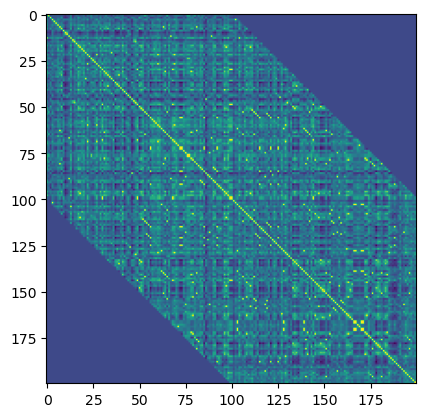

In [95]:
sents = ws
V, sent_ids = similiarity_sents(sents, 100)
plt.imshow(V[:200, :200])

In [105]:
clusters

[{'labels': {0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   1